In [100]:
# Load the dataset
import pandas as pd
import numpy as np

df = pd.read_csv('pets_prepared.csv')
df.head()

,PetID,AdoptionSpeed,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,...,HealthName,VaccinatedName,DewormedName,SterilizedName,BreedName,BreedBinsName,StateName,StateBinsName,ColorName,AdoptedName
0,86e1089a3,2,2,Nibble,3,299,0,1,1,7,...,Healthy,No,No,No,Tabby,Tabby,Selangor,Selangor,Black,Y
1,6296e909a,0,2,No Name Yet,1,265,0,1,1,2,...,Healthy,Not Sure,Not Sure,Not Sure,Domestic Medium Hair,Domestic Medium Hair,Kuala Lumpur,Kuala Lumpur,Black,Y
2,3422e4906,3,1,Brisco,1,307,0,1,2,7,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Brown,Y
3,5842f1ff5,2,1,Miko,4,307,0,2,1,2,...,Healthy,Yes,Yes,No,Mixed Breed,Mixed Breed,Kuala Lumpur,Kuala Lumpur,Black,Y
4,850a43f90,2,1,Hunter,1,307,0,1,1,0,...,Healthy,No,No,No,Mixed Breed,Mixed Breed,Selangor,Selangor,Black,Y


In [58]:
# Check dimensions of data
df.shape

(14993, 49)

In [59]:
# Investigate the nature of data in the AgeBins column, which seems less intuitive to me
df['AgeBins'].value_counts()

AgeBins
[  3,  6)    3670
2            3503
[  0,  2)    2483
[ 24, 60)    1601
[  6, 12)    1588
[ 12, 24)    1557
[ 60,255]     591
Name: count, dtype: int64

In [60]:
mask = df['AgeBins'] == '2'
print(df.loc[mask, 'Age'].value_counts())
all_age_2 = (df.loc[mask, 'Age'] == 2).all()

print(all_age_2)

# Seems strange there are so many pets in the '2' category, but they are not wrongly classified

Age
2    3503
Name: count, dtype: int64
True


In [61]:
df['BreedBins'].value_counts()

BreedBins
307       5927
266       3634
Others    3272
265       1258
299        342
264        296
292        264
Name: count, dtype: int64

In [62]:
df[['BreedBins', 'BreedName']].head(50)

# 307 corresponds with Mixed Breed
# All the less common breeds are grouped together in the 'Other' category
# We may want to encode the less common breeds as well depending on the entropy of the column

,BreedBins,BreedName
0,299,Tabby
1,265,Domestic Medium Hair
2,307,Mixed Breed
3,307,Mixed Breed
4,307,Mixed Breed
5,266,Domestic Short Hair
6,264,Domestic Long Hair
7,307,Mixed Breed
8,265,Domestic Medium Hair
9,265,Domestic Medium Hair


In [63]:
# Investigate the frequency of the "Breed1" column
df['Breed1'].value_counts()

Breed1
307    5927
266    3634
265    1258
299     342
264     296
       ... 
176       1
214       1
125       1
123       1
81        1
Name: count, Length: 176, dtype: int64

In [64]:
# Investigate the frequency of the "Breed2" column
df['Breed2'].value_counts()

Breed2
0      10762
307     1727
266      599
265      321
299      138
       ...  
104        1
36         1
17         1
257        1
279        1
Name: count, Length: 135, dtype: int64

In [65]:
# The number of unique values in the "Breed1" and "Breed2" columns is quite high. 
# I suspect that Breed can be encompassed by FurLength and BreedPure since majority of pets 
# are mixed breed or domestic

In [66]:
def process_df(df):
    # Change all columns into categorical columns
    y = df['AdoptionSpeed']

    # Column 32 onwards are all derived values or labels which have already been encoded
    # We will keep BreedPure, ColorAmt and NameorNO though because the information may be lost when we remove the original columns
    x = df.iloc[:,:34].drop('AdoptionSpeed', axis=1)

    # We may deal with these columns later, they are difficult to encode/likely not useful for analysis
    x = x.drop(['PetID', 'Name', 'Description', 'RescuerID'], axis=1)

    # Remove numerical columns because they have been binned
    x = x.drop(['Breed1', 'Breed2', 'Age', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt'], axis=1)
    return x, y

x, y = process_df(df)

# Find columns with missing values
x.isnull().sum()

# No missing values!

Type            0
Gender          0
Color1          0
Color2          0
Color3          0
MaturitySize    0
FurLength       0
Vaccinated      0
Dewormed        0
Sterilized      0
Health          0
AgeBins         0
FeeBins         0
BreedBins       0
StateBins       0
VideoAmtBins    0
PhotoAmtBins    0
QuantityBins    0
BreedPure       0
ColorAmt        0
NameorNO        0
dtype: int64

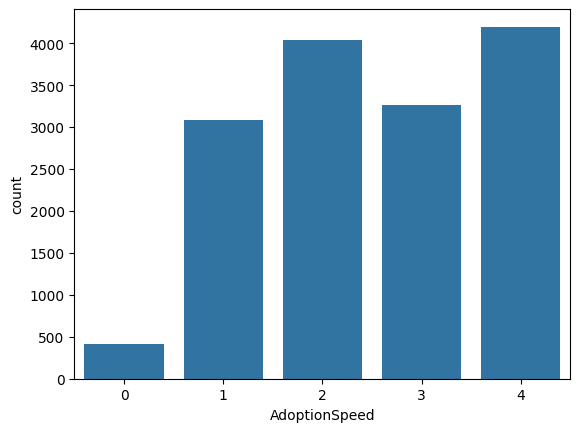

In [67]:
# Visualise distribution of the target AdoptionSpeed variable
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=y.value_counts().index, y=y.value_counts())
plt.show()

c:\Users\user\github-projects\aichallenge\venv\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


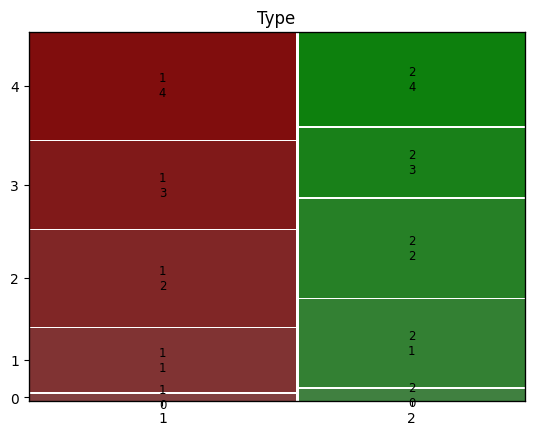

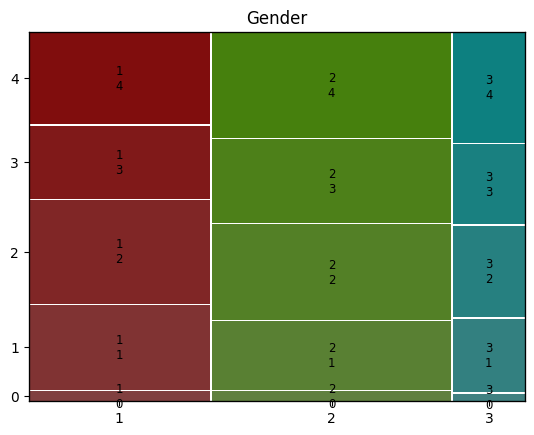

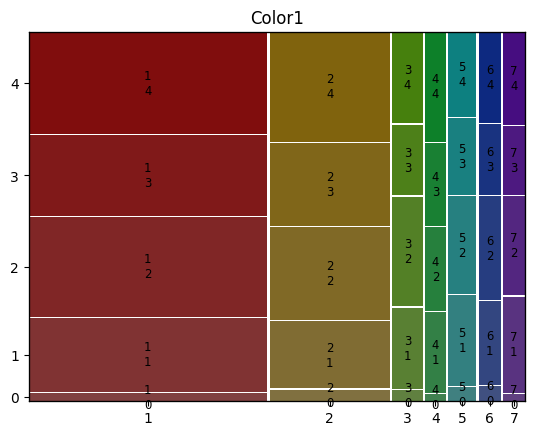

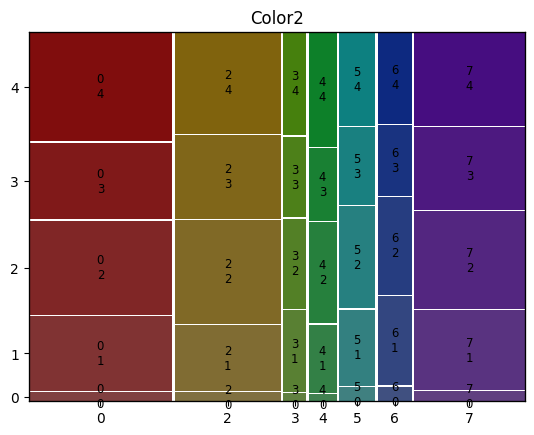

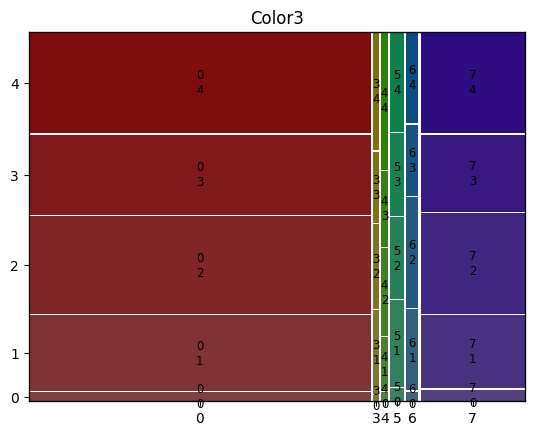

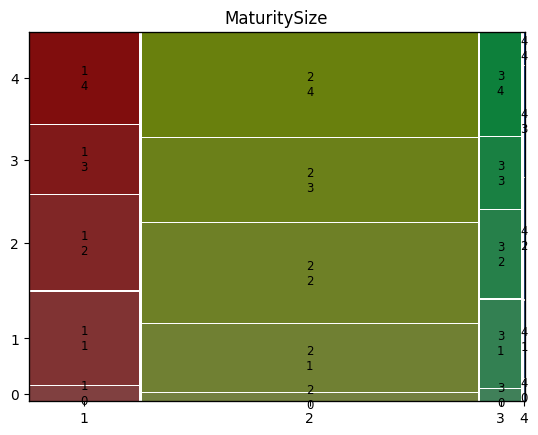

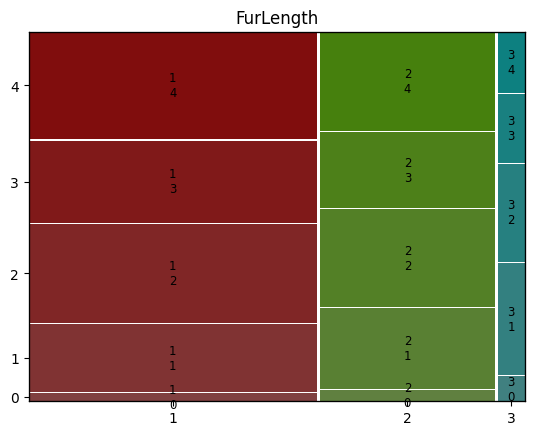

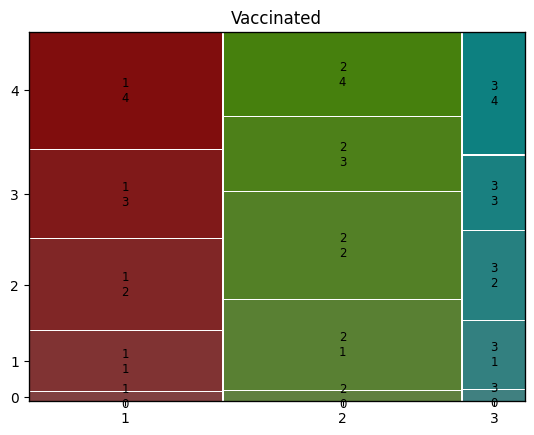

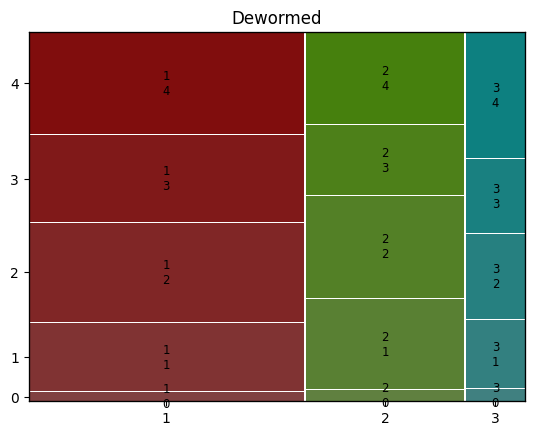

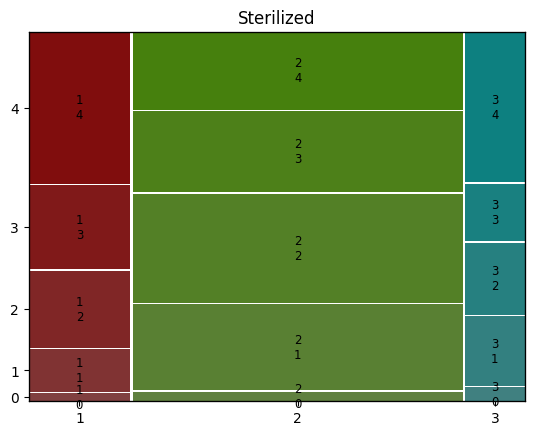

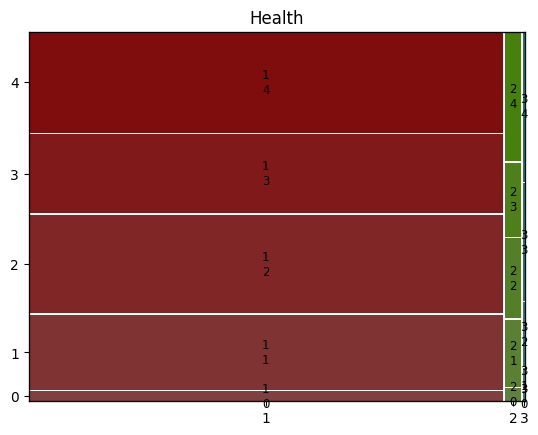

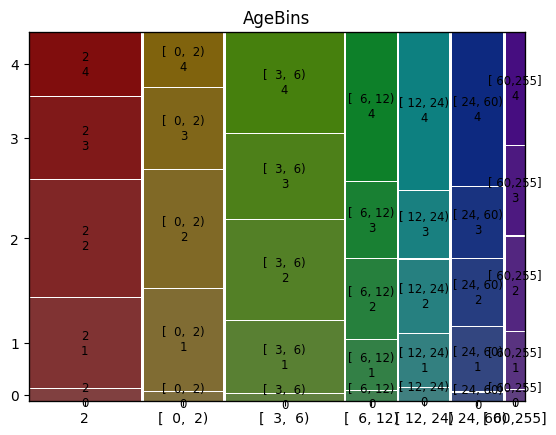

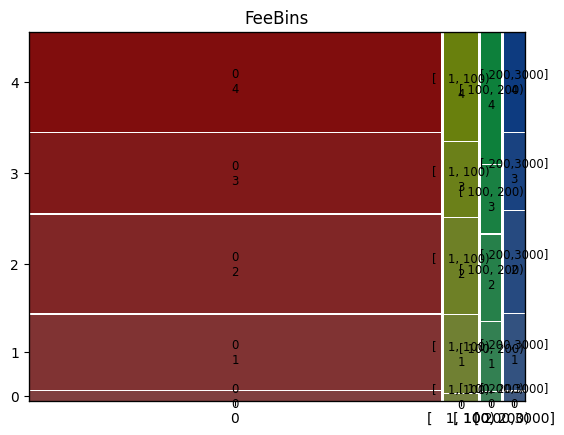

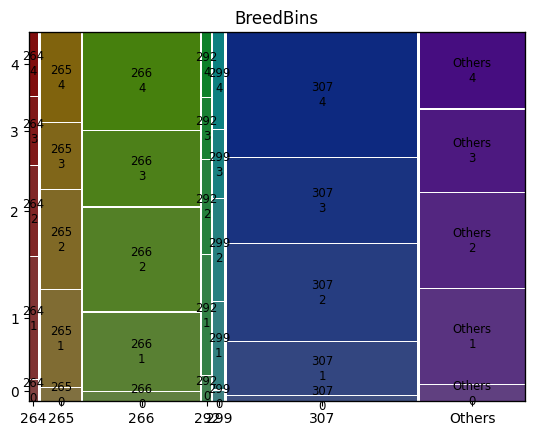

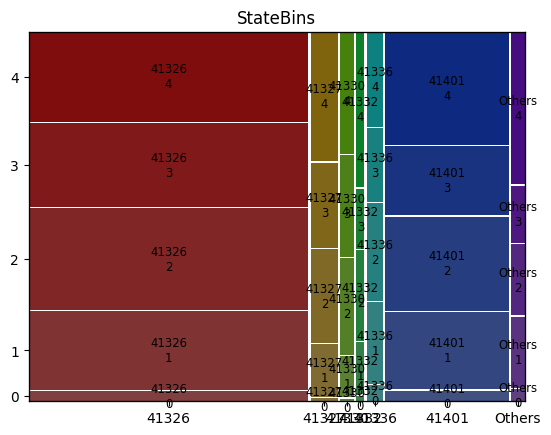

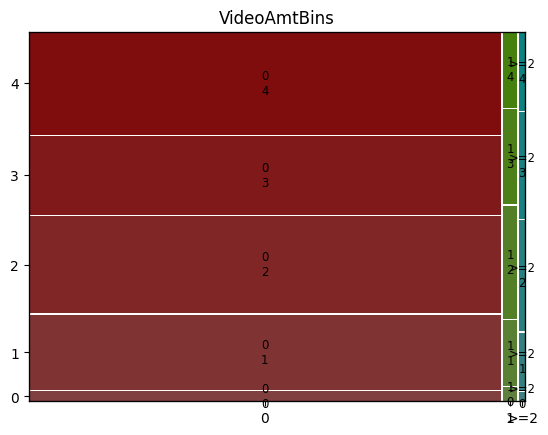

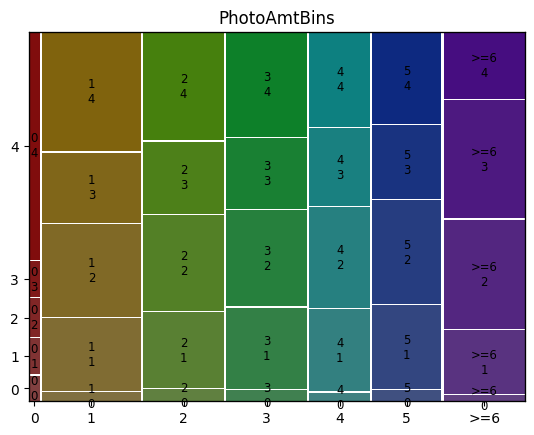

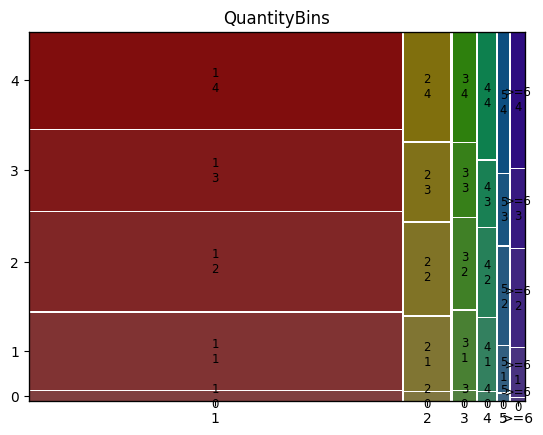

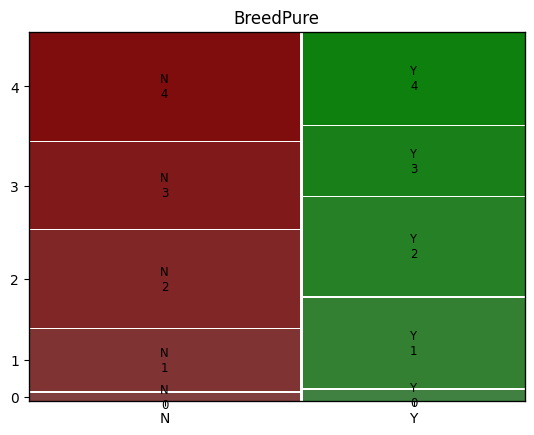

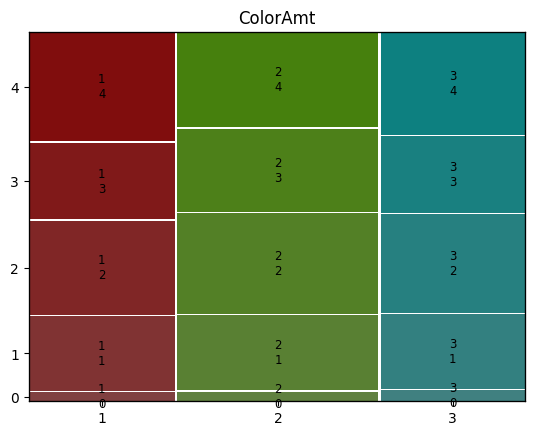

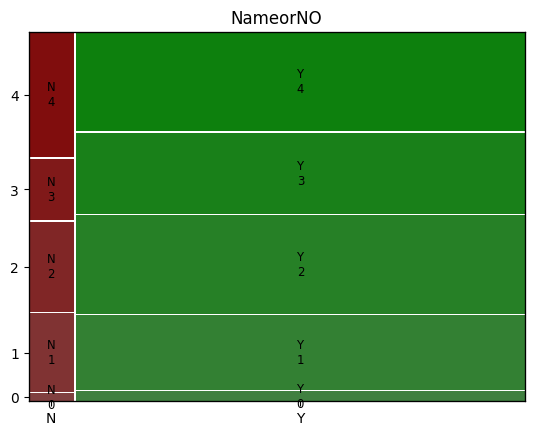

In [101]:
# Visualise each column against the target AdoptionSpeed variable
from statsmodels.graphics.mosaicplot import mosaic


for column in x.columns:
    # Sort the DataFrame
    df_sorted = df.sort_values(by=['AdoptionSpeed', column])
    mosaic(df_sorted, [column, 'AdoptionSpeed'], title=column)


# Commenting this cell out because it takes some time to run and output clutters the screen
# Uncomment to view the mosaic plots

In [ ]:
# Focusing on the FeeBins plot, initially I wanted to make a variable 
# determining how "expensive" the pet is relatively to other pets of similar breed and age
# However, the plot shows that a large proportion of pets are free, so there may be insufficient
# data to make a meaningful comparison

# Furthermore, considering the ethical requirements of the project, it may be inappropriate to
# make a variable that could potentially influence the adoption of pets based on their price.
# We may not want to encourage "budget shopping" for pets!

<Axes: >

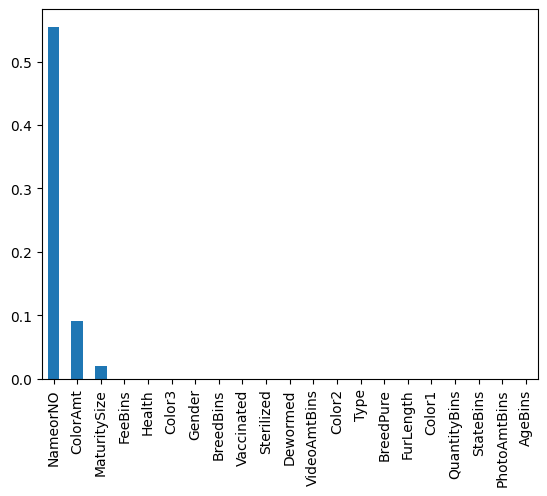

In [69]:
# Test which columns are significant

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OrdinalEncoder

# Split into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Ordinal encoding assumes that the data is ordinal, which is not the case for most columns in this dataset
# However, this should be fine for the chi-squared test, which ignores the ordinal nature of the data
# The chi-squared test is used to determine if two categorical variables are independent
# If a column is independent of the target variable, it suggests that it is not useful for prediction

x_ordinal = x_train.copy()
oe = OrdinalEncoder()
x_ordinal = oe.fit_transform(x_ordinal)

chi_scores = chi2(x_ordinal, y_train)
p_values = pd.Series(chi_scores[1],index = x.columns)
p_values.sort_values(ascending = False , inplace = True)

# Plot the p-values
p_values.plot.bar()

# It seems like we can drop the NameorNO and ColorAmt columns

In [70]:
# Test independence between BreedPure and BreedBins
from scipy.stats import chi2_contingency

contingency = pd.crosstab(x_train['BreedBins'], x_train['BreedPure'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# Test independence between FurLength and BreedBins
contingency = pd.crosstab(x_train['BreedBins'], x_train['FurLength'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# The columns are not independent as ex_trainpected, especially since BreedPure is derived from the Breed

# Test independence between BreedPure and FurLength
contingency = pd.crosstab(x_train['FurLength'], x_train['BreedPure'])
chi2, p, dof, ex = chi2_contingency(contingency)
print(chi2, p)

# Actually, the columns are independent! In this case, let's keep all of them.

7256.688658336328 0.0
4802.6120231857485 0.0
87.42699401226184 1.0362617441868428e-19


Index(['NameorNO', 'Color1', 'FeeBins', 'BreedPure', 'VideoAmtBins',
       'MaturitySize', 'Color3', 'ColorAmt', 'Gender', 'Color2', 'StateBins'],
      dtype='object')


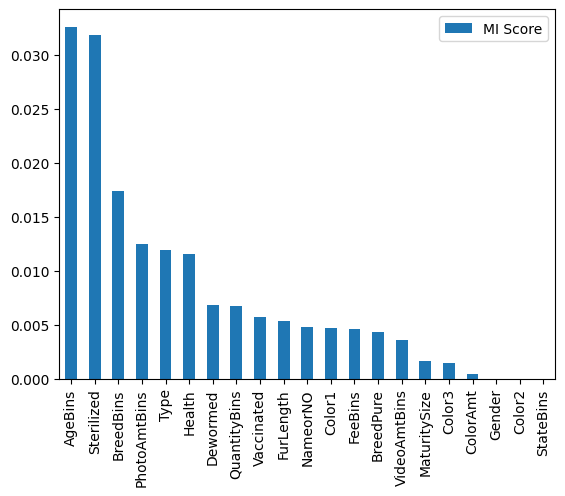

In [71]:
# Only two columns were dropped, let's see if we can reduce the number of columns by considering mutual information gain as well
# Jason Brownlee: "Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable."

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(x_ordinal, y_train)

# Create a DataFrame of the scores
mi_scores = pd.DataFrame(fs.scores_, index=x.columns, columns=['MI Score'])
mi_scores.sort_values(by='MI Score', ascending=False, inplace=True)

# Plot the scores
mi_scores.plot.bar()

# We can try eliminating columns with mutual information score less than 0.005
to_drop = mi_scores.index[mi_scores['MI Score'] < 0.005]
print(to_drop)

In [72]:
# Let's test the performances of feature selected datasets with logistic regression
# Linear regression is appropriate here because the AdoptionSpeed variable we're predicting
# is ordinal in nature
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# First, test with the entire dataset

# Hot encode the data because logistic regression assumes that the data is continuous
from sklearn.preprocessing import OneHotEncoder

x_hot_train = x_train.copy()
ohe = OneHotEncoder()
x_hot_train = ohe.fit_transform(x_hot_train)

x_hot_test = x_test.copy()
x_hot_test = ohe.transform(x_hot_test)

# Train the model
model = LinearRegression()
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)
# Round the predictions to the nearest integer
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.2750916972324108


In [73]:
# Now, test with the feature selected dataset from the chi-squared test
x_train_chi = x_train.drop(['NameorNO', 'ColorAmt'], axis=1)
x_test_chi = x_test.drop(['NameorNO', 'ColorAmt'], axis=1)

x_hot_train_chi = x_train_chi.copy()
x_hot_train_chi = ohe.fit_transform(x_hot_train_chi)

x_hot_test_chi = x_test_chi.copy()
x_hot_test_chi = ohe.transform(x_hot_test_chi)

# Train the model
model = LinearRegression()
model.fit(x_hot_train_chi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_chi)
# Round the predictions to the nearest integer
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Very similar performance

0.2750916972324108


In [74]:
# Finally, test with the feature selected dataset from the mutual information gain test
x_train_mi = x_train.drop(to_drop, axis=1)
x_test_mi = x_test.drop(to_drop, axis=1)

x_hot_train_mi = x_train_mi.copy()
x_hot_train_mi = ohe.fit_transform(x_hot_train_mi)

x_hot_test_mi = x_test_mi.copy()
x_hot_test_mi = ohe.transform(x_hot_test_mi)

# Train the model
model = LinearRegression()
model.fit(x_hot_train_mi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_mi)
# Round the predictions to the nearest integer
y_pred = np.round(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# 0.7% worse than the model with all features - might as well keep all the features since dataset isn't too large

0.2720906968989663


In [75]:
# Linear regression seems to be performing quite poorly, let's try a different model
# We can try a decision tree model, which is appropriate for classification problems

from sklearn.tree import DecisionTreeClassifier

# Train the model
model = DecisionTreeClassifier()
model.fit(x_ordinal, y_train)

# Make predictions
x_ordinal_test = x_test.copy()
x_ordinal_test = oe.transform(x_ordinal_test)
y_pred = model.predict(x_ordinal_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The decision tree model performs much better than the linear regression model (0.3221)

0.3211070356785595


In [76]:
# Try a random forest model
from sklearn.ensemble import RandomForestClassifier

# Train the model
model = RandomForestClassifier()
model.fit(x_ordinal, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The random forest model performs even better than the decision tree model (0.3881)

0.3907969323107703


In [77]:
# Try a gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier

# Train the model
model = GradientBoostingClassifier()
model.fit(x_ordinal, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# The gradient boosting model performs the best so far (0.3914)

0.39179726575525176


In [97]:
# Hmm, since classification models seem to be performing well, let's try a logistic regression model too
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train, y_train)

# Make predictions
y_pred = model.predict(x_hot_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Turns out logistic regression performs even better! (0.3965)
# Perhaps the AdoptionSpeed variable acts more like a nominal variable 
# since bins are not linear?

0.39713237745915303


In [ ]:
# Also check if it makes sense to split the dataset into dogs (Type = 1) and cats (Type = 2)
# because the distributions of the target variable may be different for each type

mask = df['Type'] == 1
dogs = df.loc[mask, :]
cats = df.loc[~mask, :]
print(dogs.shape)
print(cats.shape)

(8132, 49)
(6861, 49)


In [95]:
x_dogs, y_dogs = process_df(dogs)

# Split into train and test sets
x_train_dogs, x_test_dogs, y_train_dogs, y_test_dogs = train_test_split(x_dogs, y_dogs, test_size=0.2, random_state=0)

# Hot encode the data
x_hot_train_dogs = x_train_dogs.copy()
x_hot_train_dogs = ohe.fit_transform(x_hot_train_dogs)

x_hot_test_dogs = x_test_dogs.copy()
x_hot_test_dogs = ohe.transform(x_hot_test_dogs)

# Fit the linear regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_dogs, y_train_dogs)

# Test the performance
y_pred_dogs = model.predict(x_hot_test_dogs)
y_pred_dogs = np.round(y_pred_dogs)

accuracy_dogs = accuracy_score(y_test_dogs, y_pred_dogs)
print(accuracy_dogs)

# Accuracy is slightly better!

0.4074984634296251


In [96]:
# Now, test with cats
x_cats, y_cats = process_df(cats)

# Split into train and test sets
x_train_cats, x_test_cats, y_train_cats, y_test_cats = train_test_split(x_cats, y_cats, test_size=0.2, random_state=0)

# Hot encode the data
x_hot_train_cats = x_train_cats.copy()
x_hot_train_cats = ohe.fit_transform(x_hot_train_cats)

x_hot_test_cats = x_test_cats.copy()
x_hot_test_cats = ohe.transform(x_hot_test_cats)

# Fit the linear regression model
model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_cats, y_train_cats)

# Test the performance
y_pred_cats = model.predict(x_hot_test_cats)
y_pred_cats = np.round(y_pred_cats)

accuracy_cats = accuracy_score(y_test_cats, y_pred_cats)
print(accuracy_cats)

# Oh, accuracy suffers for cats though
# Splitting into dogs and cats may not be a good idea

0.37509104151493083


In [102]:
# Test gradient boosting and logistic regression models with dropped columns from chi-squared test
x_train_chi = x_train.drop(['NameorNO', 'ColorAmt'], axis=1)
x_test_chi = x_test.drop(['NameorNO', 'ColorAmt'], axis=1)

x_ordinal_train_chi = x_train_chi.copy()
x_ordinal_train_chi = oe.fit_transform(x_ordinal_train_chi)

x_ordinal_test_chi = x_test_chi.copy()
x_ordinal_test_chi = oe.transform(x_ordinal_test_chi)

# Train gradient boosting model
model = GradientBoostingClassifier()
model.fit(x_ordinal_train_chi, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test_chi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for gradient boosting model: {accuracy}")

# Train logistic regression model
x_hot_train_chi = x_train_chi.copy()
x_hot_train_chi = ohe.fit_transform(x_hot_train_chi)

x_hot_test_chi = x_test_chi.copy()
x_hot_test_chi = ohe.transform(x_hot_test_chi)

model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_chi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_chi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for logistic regression model: {accuracy}")

# Gradient boosting: 0.3914 (all features), 0.3898 (chi-squared test) 
# Logistic regression: 0.3965 (all features), 0.3975 (chi-squared test)

accuracy for gradient boosting model: 0.38979659886628876
accuracy for logistic regression model: 0.3974658219406469


In [103]:
# Test gradient boosting and logistic regression models with dropped columns from mutual information gain test
x_train_mi = x_train.drop(to_drop, axis=1)
x_test_mi = x_test.drop(to_drop, axis=1)

x_ordinal_train_mi = x_train_mi.copy()
x_ordinal_train_mi = oe.fit_transform(x_ordinal_train_mi)

x_ordinal_test_mi = x_test_mi.copy()
x_ordinal_test_mi = oe.transform(x_ordinal_test_mi)

# Train gradient boosting model
model = GradientBoostingClassifier()
model.fit(x_ordinal_train_mi, y_train)

# Make predictions
y_pred = model.predict(x_ordinal_test_mi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for gradient boosting model: {accuracy}")

# Train logistic regression model
x_hot_train_mi = x_train_mi.copy()
x_hot_train_mi = ohe.fit_transform(x_hot_train_mi)

x_hot_test_mi = x_test_mi.copy()
x_hot_test_mi = ohe.transform(x_hot_test_mi)

model = LogisticRegression(max_iter=1000)
model.fit(x_hot_train_mi, y_train)

# Make predictions
y_pred = model.predict(x_hot_test_mi)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy for logistic regression model: {accuracy}")

# Gradient boosting: 0.3914 (all features), 0.3898 (chi-squared test), 0.3871 (mutual information gain test)
# Logistic regression: 0.3965 (all features), 0.3975 (chi-squared test), 0.3868 (mutual information gain test)
# The logistic regression model with the chi-squared test feature selected dataset performs the best

accuracy for gradient boosting model: 0.3871290430143381
accuracy for logistic regression model: 0.3867955985328443


In [ ]:
# Now let's move on with processing the text data!
text_train_x = df[['Name','Description']].iloc[x_train.index]
text_test_x = df[['Name','Description']].iloc[x_test.index]

print(text_train_x.head())

                    Name                                        Description
4977              Vanila  / Adorable local mix Persian kitten looking fo...
14176          Cliff-ord  Clifford and his 3 siblings need a home. Mothe...
2137   â¥ ..Teddy.. â¥  Introducing Teddy! ♥ Adult male Shih Tzu, 1+ y...
14768               Kiss  Poor Kiss was rescued off a road while he/she ...
14437                Sam  Sam has lots of love to give! He even has a lo...


In [ ]:
# The text contains a lot of special characters and some typos that we need to clean up
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^a-z\s0-9]', '')
    text = text.str.replace(r'\s+', ' ')
    return text

text_train_x['Name'] = clean_text(text_train_x['Name'])
text_train_x['Description'] = clean_text(text_train_x['Description'])

print(text_train_x.head())

text_test_x['Name'] = clean_text(text_test_x['Name'])
text_test_x['Description'] = clean_text(text_test_x['Description'])

                    Name                                        Description
4977              vanila  / adorable local mix persian kitten looking fo...
14176          cliff-ord  clifford and his 3 siblings need a home. mothe...
2137   â¥ ..teddy.. â¥  introducing teddy! ♥ adult male shih tzu, 1+ y...
14768               kiss  poor kiss was rescued off a road while he/she ...
14437                sam  sam has lots of love to give! he even has a lo...


In [ ]:
from spellchecker import SpellChecker
spell = SpellChecker()

# Find misspelled words
misspelled = set()
for row in text_train_x['Description']:
    if pd.notnull(row):
        words = row.split()
        misspelled = misspelled.union(spell.unknown(words))

print(misspelled)
print(len(misspelled))
# Quite a number of typos!

{'too!', 'pasar.', 'rescues,', 'ragdoll', 'kedah.', 'fax:', 'kidney.', 'lassie,', 'stress.', 'car!', 'script.', '1female(black).', 'girl....area', 'along..any', '8"(h)],', 'days!', 'sleeping.', 'feet/lap/shoulders.', 'mundar', 'fast-', 'neighbourhood.we', '(ie', 'friend".', 'information!', 'them).', 'smpai', 'selatan.(self-collect)', 'face,', 'rat!', 'is--', 'living.', 'pet....please', 'found,', 'kwin', 'choices.', 'jolly,', 'active/young', '6pm.', 'thanks.!', 'mork', 'doggie.....he', "'hump'", 'that"s', 'not-too-bad', 'libby', 'mah~~).', 'balls...very', 'nutrients,', 'died)', 'persion', 'social.', 'dachsun', '"fish"', '4)在约定好之后，我能够登门看看狗狗', 'betul....skang', '(non-negotiable)', 'e-mails', 'good).', 'mom...she', 'area..', 'juu', 'sylvester,', 'emmet.', 'girl(brown', 'enquiries,pls', 'guna', '***', 'cny!!', 'neighbourhood', 'world.their', 'chance?', 'yup,', 'softer.', 'exceptions.', 'split-faced', '2.always', 'here,&', 'tan).', 'mouth,', 'hhaha...', 'me...after', 'home.anyone', 'growth.'

In [ ]:
# Correct misspelled words with TextBlob
from textblob import TextBlob

def correct_spelling(text):
    if pd.isnull(text):
        return text
    tb = TextBlob(text)
    return str(tb.correct())

text_train_x['Description'] = text_train_x['Description'].apply(correct_spelling)

# Test number of misspelled words again
misspelled = set()
for row in text_train_x['Description']:
    if pd.notnull(row):
        words = row.split()
        misspelled = misspelled.union(spell.unknown(words))

print(misspelled)
print(len(misspelled))

# Number of identified typos reduced from 13005 to 6178
# Here, TextBlob took an extremely long time, about 6 hours...
# Another solution to consider is symspellpy, which claims to six orders of magnitude faster

ModuleNotFoundError: No module named 'textblob'

In [ ]:
# Write the new data to a csv file
text_train_x.to_csv('text_train_x.csv', index=False)
text_test_x.to_csv('text_test_x.csv', index=False)